# ResNet 구현

시간이 예전과 다르게 비교적 많으니, 제대로 해보고 싶은 마음에 나름대로 절차를 나누어봤다. 
1. 라이브러리 및 데이터 로딩과 전처리  
   - 필요 라이브러리 불러오기
   - 데이터 불러오기
   - 데이터 기본 정보(데이터의 구성, 입력 데이터의 형태, 레이블) 확인
   - 데이터 정규화(및 데이터 출력까지 확인)
2. 모델 설계
   - 모델의 구조(ResNet 34, 50)의 구조 파악
   - 모델에 사용할 block을 만드는 함수 만들기  
       (입력: 입력 layer, block안의 layer수,  출력 channel 수, 블록 이름(순서))
       (출력: block, 블록 내부의 layer들이 중첩된 형태이다.)
       : block 내부의 layer를 설정한다.
   - 모델 생성 함수 만들기  
       (입력: 입력 이미지 shape, block안의 layer개수[리스트], 출력 channel 수[리스트], 분류 데이터의 클래스(레이블) 수)   
       (출력: model, block의 중첩, 정확히 말하면 block 안의 layer들이 모두 중첩된 형태)
       :block만드는 함수를 호출하여 전체 모델을 생성한다.
3. 모델 실행
   - 컴파일
   - 학습
   - 검증 정확도 비교(history)

#### 1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?
블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.  
  
#### 2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?
tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.  
  
#### 3. Ablation Study 결과가 바른 포맷으로 제출되었는가?
ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

## 1. 라이브러리 및 데이터 로딩과 전처리

### 필요 라이브러리 불러오기  

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds

### 데이터 불러오기

In [2]:
# 데이터를 불러온다. 불러올 데이터는 cifar 10을 사용하며, train-test 셋을 나누고, 데이터 정보를 불러오며, shuffle을 실시한다.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(train_data, test_data), data_info=tfds.load(name='cats_vs_dogs',
               split=['train[:70%]', 'train[70%:]'],
                with_info=True,
                shuffle_files=True)

### 데이터 기본 정보 확인
받은 데이터의 타입과 크기, 정보를 확인해 보았다.

In [3]:
type(train_data)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [4]:
print(tf.data.experimental.cardinality(train_data))
print(tf.data.experimental.cardinality(test_data))

tf.Tensor(16283, shape=(), dtype=int64)
tf.Tensor(6979, shape=(), dtype=int64)


In [5]:
data_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    t

In [22]:
data_info.features["label"].num_classes

2

In [23]:
data_info.features["label"].names

['cat', 'dog']

총 데이터는 23,262개로, 데이터의 70%(16283개 데이터)는 훈련용, 30%(6979개 데이터)는 테스트용으로 사용하기로 하였다. cats_vs_dogs인 만큼 class는 'cat', 'dog' 두 개였다.

### 데이터 정규화
데이터를 정규화시켜 더욱 효과적인 학습이 이루어지도록 한다. 데이터를 정규화시키면 분포에 변화가 생겨 좀 더 학습에 용이한 형태로 바뀌는데, 데이터의 변형이나 손실은 없기 때문에 사용한다. 이는 데이터 편차가 줄어드는 것과도 관련이 있다. 정규화에 사용되는 함수는 노드를 참고하였다. 

In [14]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
#     print('normalize_and_resize_img 입력값:', type(image))
    image = tf.image.resize(image, [32, 32])
#     print('normalize_and_resize_img 출력값:', type(image))
    return tf.cast(image, tf.float32) / 255., label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
#     print("map을 거친 data:", type(ds))
    ds = ds.batch(batch_size)
#     print("batch를 거친 data:", type(ds))
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     print("return data:", type(ds))
    return ds

## 2. 모델 설계
### ResNet 34, 50의 구조

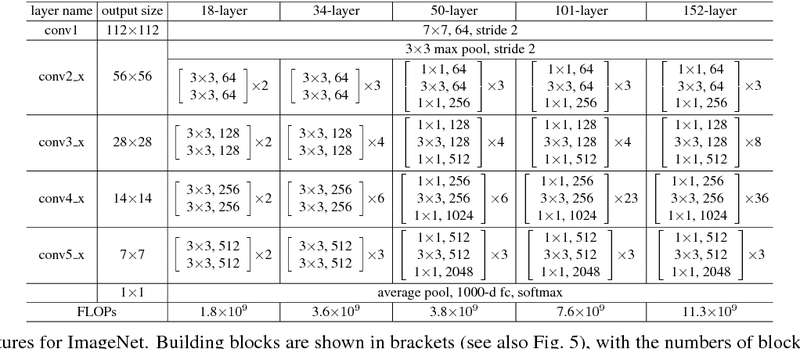

ResNet은 총 4개의 block으로 구성되어 있다고 보아도 무방(그림의 conv2_x~conv5_x, conv1은 단층 conv layer다)하며 각 block 안에 skip connection이 만들어진 conv layer들이 들어 있다.  
위의 그림을 예로 들어 설명하겠다. 34-layer의 conv2_x 에는 3x3, 64라는 숫자 두 묶음이 대괄호([ ])안에 들어 있다.   
대괄호는 skip connection을 수행할 단위를 의미하며, 여기에는 3x3, 64인 conv layer가 둘 들어가 있다.  
3x3이 의미하는 바는 커널의 크기이며, 64는 출력 채널이다. 대괄호 옆에는 x3이 있는데, 위와 같은 대괄호 묶음이 3개가 들어있는 block이 conv2_x block이라는 의미다.  
정리하면, 34 layer의 conv2_x block에는 skip connection이 형성된 3x3, 64크기의 conv layer 2개가 3개씩 들어가 있다는 뜻이 된다.  
또한 conv layer를 하나 건너면 batch normalization과 activation layer가 하나씩 들어가게 된다.(+ skip connection을 형성하는 layer도 군데군데 들어간다.)
  
위의 그림을 기반으로 ResNet-34와 50을 코딩해 보도록 하겠다.

### block 함수 만들기
layer를 수동으로 하나씩 쌓는 것은 복잡하고 비효율적이기 때문에 ResNet구성에 필요한 정보를 인자로 받아 block을 자동으로 구성하는 함수를 만들어 볼 것이다. 이 함수를 통해 34와 50의 block을 만들어 볼 것이다. 입력받을 인자는 다음과 같다.  
  
input_layer: 입력 받는 값, layer
block_num: 몇 번째 block인지  
skip_num: block안에 몇 개의 skip connection이 구현되어야 하는지(block안에 몇 개의 conv layer 묶음이 있는지)  
kernel_size: 각 conv layer의 kernel size  
channel_size: 각 layer의 출력 channel  
is_plain: skip connection 여부 확인  

return값은 conv layer의 block

In [ ]:
def build_resnet_block(input_layer,
                    block_num=1,
                    skip_num=3,
                    skip_layers=2,
                    kernel_size=[3,3], 
                    channel_size=[64, 64],
                    is_plain=False,
                   ):
    # 입력 레이어
    x = input_layer

    for num_skip in range(skip_num):
        for layer_skip, kernel, channel in zip(range(skip_layers),kernel_size, channel_size):
            x= keras.layers.Conv2D(
                filters=channel,
                kernel_size=(kernel, kernel),
                activation='relu'
                kernel_initializer='he_normal',
                padding='same'
                name=f'convblock{block_num}_sknum{num_skip}_lanum{layer_skip}'
            )(x)
            
            x=keras.layers.BatchNormalization(x)
            
            
            
            

#     # Max Pooling 레이어
#     x = keras.layers.MaxPooling2D(
#         pool_size=(2, 2),
#         strides=2,
#         name=f'block{block_num}_pooling'
#     )(x)

    return x